In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is

## Import model

Importing model via the traditional transformers , then loading components for Parameter Effcient Fine Tuning using the 🤗 `PEFT` library and `bitsandbytes` for loading large models in 8-bit. The fine-tuning method will rely on a recent method called "Low Rank Adapters" (LoRA)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [4]:
model.dtype, model.device

(torch.float32, device(type='cpu'))

## Post Process the Model

In order to isolate other paramters and train only few params and the adaptors we need to disable gradients on other layes and upcast the `LayerNorm` to `float32` for stability.

`model.enable_input_require_grads()` Enables the gradients for the input embeddings. This is useful for fine-tuning adapter weights while keeping the model weights fixed.

In [5]:
for param in model.parameters():
  param.requires_grad = False # Freeze the model weights and train the adapter
  if param.ndim == 1:
     param.data = param.data.to(torch.float32) # Upcast small paramters like Layer Norm

# Gradient checkpoint
model.gradient_checkpointing_enable() # Reduce the number of stored activations
model.enable_input_require_grads() # Enables the gradients for the input embeddings.

## LoRA

Load the `PeftModel` and specify that we're gonna use LoRA using `get_peft_model` utility from `peft`. Specify the adaptors using the `LoraConfig`

In [6]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [7]:
from peft import get_peft_model, LoraConfig

config = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ['q_proj','k_proj','v_proj'],
    lora_dropout = 0.01,
    bias = "none",
    task_type = "CASUAL_LM"
)

model = get_peft_model(model, config)

## Load Data and Train

In [8]:
import transformers
from datasets import load_dataset
data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

In [10]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=0,
        max_steps=1,
        learning_rate=2e-4,
        fp16=False,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference

max_steps is given, it will override any value given in num_train_epochs


In [11]:
trainer.train()

Step,Training Loss
1,2.825400


TrainOutput(global_step=1, training_loss=2.82539701461792, metrics={'train_runtime': 98.2003, 'train_samples_per_second': 0.163, 'train_steps_per_second': 0.01, 'total_flos': 3809979777024.0, 'train_loss': 2.82539701461792, 'epoch': 0.006379585326953748})

# Parameter Efficient Fine Tuning with TRL

## Setup Instalation

First step is to install Hugging Face Libraries and Pyroch, including trl, transformers and datasets.

If you are using a GPU with Ampere architecture (e.g. NVIDIA A10G or RTX 4090/3090) or newer you can use Flash attention. Flash Attention is a an method that reorders the attention computation and leverages classical techniques (tiling, recomputation) to significantly speed it up and reduce memory usage from quadratic to linear in sequence length. The TL;DR; accelerates training up to 3x


In [1]:
# Install Hugging Face libraries
!pip -q install datasets
!pip -q install accelerate
!pip -q install bitsandbytes peft trl
!pip -q install transformers==4.38.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", whi

In [15]:
# import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'
# # install flash-attn
# !pip install ninja packaging
# !MAX_JOBS=4 pip install flash-attn --no-build-isolation

## Dataset

In this example ` sql-create-context` dataset will be used which contains natural language instructions, schema definitions and the corresponding SQL query.

In [2]:
from datasets import load_dataset

# Load dataset from the hub
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle().select(range(12500))

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

With the latest release of `trl` we now support popular instruction and conversation dataset formats. This means we only need to convert our dataset to one of the supported formats and `trl` will take care of the rest. Those formats include

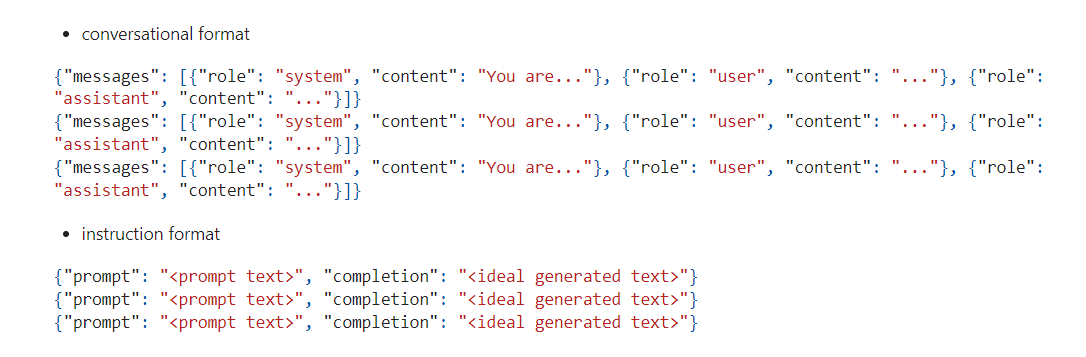

In [3]:
# Convert dataset to OAI messages
system_message = """You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.
SCHEMA:
{schema}"""

def create_conversation(sample):
  return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=sample["context"])},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  }

# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

In [4]:
print(dataset["train"][345]["messages"])

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

[{'content': 'You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.\nSCHEMA:\nCREATE TABLE table_name_95 (year INTEGER, location VARCHAR)', 'role': 'system'}, {'content': 'What was the earliest year a game was played in Athens?', 'role': 'user'}, {'content': 'SELECT MIN(year) FROM table_name_95 WHERE location = "athens"', 'role': 'assistant'}]


Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

1191401

## Fine-Tuning with SFTTrainer

We will use the SFTTrainer from `trl` to fine-tune our model. The `SFTTrainer` makes it straightfoward to **supervise fine-tune** open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features, including logging, evaluation, and checkpointing, but adds additiional quality of life features, including:

-

In [11]:
from datasets import load_dataset

# Load jsonl data from disk
dataset = load_dataset("json", data_files="/content/train_dataset.json",
                       split="train")

dataset

Dataset({
    features: ['messages'],
    num_rows: 10000
})

**WHEN TO USE SFTTrainer ??**

Supervised Fine Tuning Trainer (SFTTrainer) is used for Instruct Fine Tuning. The HuggingFace library SFTTrainer has also support for training with QLoRA (4-bit Quantised model forward pass and LoRA adapters), and also saving the model with that. From the source code the actual work is done by the Trainer baseclass. Note that both the classes are Supervised in that they use the next label (Causal LM ) as the target.

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import setup_chat_format

# checkpoint
model_id = "microsoft/phi-1_5"

# Setup BitsAndBytes Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True)

In [7]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(model_id, device_map="cuda")
tokenizer.padding_side = 'right' # to prevent warnings

# # set chat template to OAI chatML, remove if you start from a fine-tuned model
model, tokenizer = setup_chat_format(model, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

The `SFTTrainer`  supports a native integration with `peft`, which makes it super easy to efficiently tune LLMs using. We only need to create our LoraConfig and provide it to the trainer.

In [8]:
model.dtype, model.device

(torch.bfloat16, device(type='cuda', index=0))

In [9]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=1,
        lora_dropout=0.05,
        r=1,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

In [19]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="phi-1_5-text-to-sql", # directory to save and repository id
    # num_train_epochs=3,                     # number of training epochs
    max_steps = 1,
    per_device_train_batch_size=3,          # batch size per device during training
    gradient_accumulation_steps=2,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_bnb_8bit",                 # use adamw_bnb_8bit
    logging_steps=1,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=False,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="cosine",           # use constant learning rate scheduler
    push_to_hub=False,                      # push model to hub
    report_to="none",                # report metrics to tensorboard
)

from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False, # No need to add additional separator token
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:289: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:366: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [21]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,3.339400


Checkpoint destination directory phi-1_5-text-to-sql/checkpoint-1 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:232: Us